### Análisis de Complejidad del Algoritmo Greedy - Primera parte

In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os

# Este parámetro controla cuantas veces se ejecuta el algoritmo para cada
# tamaño. Esto es conveniente para reducir el error estadístico en la medición
# de tiempos. Al finalizar las ejecuciones, se promedian los tiempos obtenidos
RUNS_PER_SIZE = 10

# Ajustar este valor si se quiere usar más de un proceso para medir los tiempos
# de ejecución, o None para usar todos los procesadores disponibles. Si se usan
# varios procesos, tener cuidado con el uso de memoria del sistema.
MAX_WORKERS = 1


def _time_run(algorithm, *args):
    start = time.time()
    algorithm(*args)
    return time.time() - start


def time_algorithm(algorithm, sizes, get_args):
    futures = {}
    total_times = {i: 0 for i in sizes}

    # Usa un ProcessPoolExecutor para ejecutar las mediciones en paralelo
    # (el ThreadPoolExecutor no sirve por el GIL de Python)
    with ProcessPoolExecutor(MAX_WORKERS) as p:
        for i in sizes:
            for _ in range(RUNS_PER_SIZE):
                futures[p.submit(_time_run, algorithm, *get_args(i))] = i

        for f in as_completed(futures):
            result = f.result()
            i = futures[f]
            total_times[i] += result

    return {s: t / RUNS_PER_SIZE for s, t in total_times.items()}

In [2]:
# Imports necesarios para el notebook
from random import seed

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

# Siempre seteamos la seed de aleatoridad para que los # resultados sean reproducibles
seed(12345)
np.random.seed(12345)

sns.set_theme()

##### Algoritmo a ser evaluado

In [3]:
PRIMERA_S = "Primera moneda para Sophie; "
ULTIMA_S = "Ultima moneda para Sophie; "
PRIMERA_M = "Primera moneda para Mateo; "
ULTIMA_M = "Ultima moneda para Mateo; "

def obtener_moneda_mas_grande(a, b, l, r):
        if a > b:
            return a , l+1 , r, PRIMERA_S
        return b, l , r-1, ULTIMA_S

def obtener_moneda_mas_chica(a, b, l, r):
    if a < b:
        return a , l+1 , r, PRIMERA_M
    return b, l , r-1, ULTIMA_M

def solucion_greedy(monedas):
    contador_Sophia = 0
    contador_Mateo = 0
    orden_de_monedas = []
    l = 0
    r = len(monedas)-1
    turno_sophi = True
    while (l<=r):
        if turno_sophi:    
            m, l, r, lado = obtener_moneda_mas_grande(monedas[l], monedas[r], l, r)
            contador_Sophia += m
            orden_de_monedas.append(lado)
            turno_sophi = False
            continue
        m, l, r , lado = obtener_moneda_mas_chica(monedas[l], monedas[r], l, r)
        contador_Mateo += m
        orden_de_monedas.append(lado)
        turno_sophi = True

    return contador_Sophia, contador_Mateo, orden_de_monedas

### Medición y Visualización del Tiempo de ejecución del algoritmo

En esta sección generaremos arrays de distinto tamaño y mediremos el tiempo de ejecución de nuestro algoritmo de resolución Greedy aplicados a cada uno. <br>
Los resultados se grafican para obtener como el tiempo de ejecucion varia con el tamaño del arreglo, lo que nos permite analizar la complejidad temporal del algoritmo. Se puede ver que el algoritmo tiene una complejidad algoritmica lineal $O(n)$

In [4]:
def get_random_array(size: int):
    return np.random.randint(1, 10000, size)

# La variable x van a ser los valores del eje x de los gráficos en todo el notebook
# Tamaño mínimo=100, tamaño máximo=1000000, cantidad de puntos=100
x = np.linspace(100, 1000000, 100).astype(int)

In [10]:
results = time_algorithm(solucion_greedy, x, lambda s: [get_random_array(s)])

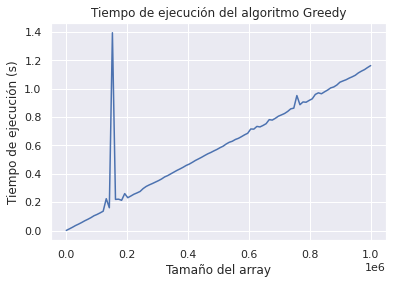

In [11]:
ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, [results[i] for i in x], label="Medición")
ax.set_title('Tiempo de ejecución del algoritmo Greedy')
ax.set_xlabel('Tamaño del array')
ax.set_ylabel('Tiempo de ejecución (s)')
None

Se puede apreciar un outlier en el tiempo de ejecución para un punto en el rango de tamaño del arreglo entre 100000-20000 elementos. Esto se puede atribuir a problemas de performance en la maquina que esta haciendo la ejecucion del algoritmo

In [19]:
for tamanio_array in results.keys():
    if results[tamanio_array] > 1 and tamanio_array < 200000:
        print(tamanio_array)

151600


Se vuelve a evaluar el tiempo de ejecución para este caso en particular

In [20]:
outlier_result = time_algorithm(solucion_greedy, [151600], lambda s: [get_random_array(s)])
outlier_result

{151600: 0.18329830169677735}

Efectivamente fue un problema propio de la computadora. Se reemplaza esta medición incorrecta

In [22]:
results[151600] = outlier_result[151600]

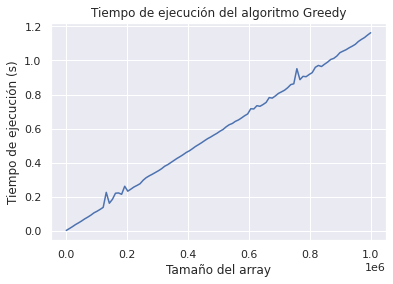

In [43]:
ax: plt.Axes
fig, ax = plt.subplots()
ax.plot(x, [results[i] for i in x], label="Medición")
ax.set_title('Tiempo de ejecución del algoritmo Greedy')
ax.set_xlabel('Tamaño del array')
ax.set_ylabel('Tiempo de ejecución (s)')
None

### Ajuste de la Complejidad con un modelo Lineal

Realizamos un ajuste de las mediciones utilizando un modelo lineal

In [44]:
# scipy nos pide una función que recibe primero x y luego los parámetros a ajustar:
f = lambda x, c1, c2: c1 * x + c2 

c, pcov = sp.optimize.curve_fit(f, x, [results[n] for n in x])

print(f"c_1 = {c[0]}, c_2 = {c[1]}")
r = np.sum((c[0] * x  + c[1] - [results[n] for n in x])**2)
print(f"Error cuadrático total: {r}")

c_1 = 1.153458925592032e-06, c_2 = 0.004518958636784244
Error cuadrático total: 0.014906766874004957


Como puede verse en el resultado obtenido, tenemos un error muy bajo, lo que nos indica que el algoritmo tiene una complejidad lineal

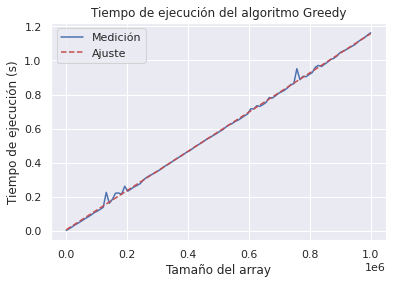

In [45]:
ax.plot(x, [c[0] * n  + c[1] for n in x], 'r--', label="Ajuste")
ax.legend()
fig

### Gráfico de evolución del error con tamaño de arreglo

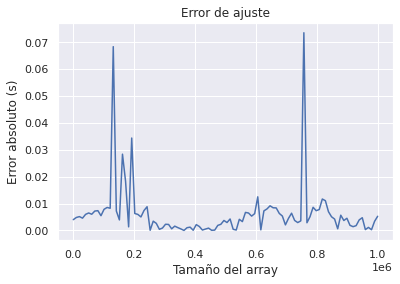

In [47]:
ax: plt.Axes
fig, ax = plt.subplots()
errors = [np.abs(c[0] * n  + c[1] - results[n]) for n in x]
ax.plot(x, errors)
ax.set_title('Error de ajuste')
ax.set_xlabel('Tamaño del array')
ax.set_ylabel('Error absoluto (s)')
None
